In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time 
import os, sys    
import copy

from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F

import cnn_utils
import global_defs

import warnings
warnings.filterwarnings('ignore')
device = torch.device("cuda")

In [2]:
train_image_file = 'sign_mnist_train.csv'

test_image_file = 'sign_mnist_test.csv'

In [3]:
train = pd.read_csv(train_image_file)

train_labels = train['label'].values

train.drop('label', axis = 1, inplace = True)

train_images = train.values
train_images = train_images.reshape(train_images.shape[0], 28, 28)

In [4]:
test = pd.read_csv(test_image_file)

test_labels = test['label'].values

test.drop('label', axis = 1, inplace = True)
    
test_images = test.values
test_images = test_images.reshape(test_images.shape[0], 28, 28)

In [5]:
class convnet(nn.Module):

    def __init__(self, classes, dropout1):

        super(convnet, self).__init__()
        
        # CL1:   28 x 28  -->    64 x 28 x 28 
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        
        # MP1: 64 x 28 x 28 -->    64 x 14 x 14
        self.pool1  = nn.MaxPool2d(2,2)
        
        # CL2:   64 x 14 x 14  -->    64 x 14 x 14 
        self.conv2 = nn.Conv2d(64,  64,  kernel_size=3, padding=1 )
        
        # MP2: 64 x 14 x 14  -->    64 x 7 x 7
        self.pool2 = nn.MaxPool2d(2,2)
        
        # CL3:   64 x 7 x 7  -->    64 x 7 x 7 
        self.conv3 = nn.Conv2d(64,  64,  kernel_size=3, padding=1 )
        
        self.to_pad = 1
        # MP3: 64 x 7 x 7  -->    64 x 4 x 4 or 64 x 3 x 3, depending on padding
        self.pool3 = nn.MaxPool2d(2,2, padding=self.to_pad)
        
        if self.to_pad:
            # LL1:   64 x 4 x 4 = 1024 -->  128 
            self.linear1 = nn.Linear(1024, 128)
        else:
            # LL1:   64 x 3 x 3 = 576 -->  128 
            self.linear1 = nn.Linear(576, 128)
        
        self.dropout1 = nn.Dropout(dropout1) 
        
        # LL2:   128  -->  classes
        self.linear2 = nn.Linear(128, classes)


    def forward(self, x):

        # CL1:   28 x 28  -->    64 x 28 x 28 
        x = self.conv1(x)
        x = F.relu(x)
        
        # MP1: 64 x 28 x 28 -->    64 x 14 x 14
        x = self.pool1(x)
        
        # CL2:   64 x 14 x 14  -->    64 x 14 x 14 
        x = self.conv2(x)
        x = F.relu(x)
        
        # MP2: 64 x 14 x 14  -->    64 x 7 x 7
        x = self.pool2(x)

        # CL3:   64 x 7 x 7  -->    64 x 7 x 7 
        x = self.conv3(x)
        x = F.relu(x)
        
        # MP3: 64 x 7 x 7  -->    64 x 4 x 4 or 64 x 3 x 3, depending on padding
        x = self.pool3(x)
        
        
        # LL1 
        if self.to_pad: x = x.view(-1, 1024)   ### reshape
        else: x = x.view(-1, 576)
        x = self.linear1(x)
        x = F.relu(x)
        
        
        # Droput
        x = self.dropout1(x)
        
        # LL2:   128  -->  classes
        x = self.linear2(x)
    
        return x
 

In [6]:
def display_num_param(self, net):
        nb_param = 0
        for param in net.parameters():
            nb_param += param.numel()
        print('There are {} ({:.2f} million) parameters in this neural network'.format(
            nb_param, nb_param/1e6)
            )


We observed the fastest rate of training convergence (over 100 epochs) for this network with learning rate of 0.001. This value is divided by 1.5 after every 10th epoch of training. 

In [7]:
my_lr = 0.001 

epochs = 10

batch_size = 128         
    
classes = 26  #### possible characters

CNNutils = cnn_utils.CNN_Utils(my_lr, batch_size, epochs)

model_name = 'Cnet_Kaggle'

## Cross Validation (CV)

The check the performance of the network on samples from training set, the data is randomly split into 90% training and 10% validation portions in 10 iterations of CV.


In [8]:
def CrossEval(dropout):
    
        CV = 10
        
        train_history_over_CV = []
        val_history_over_CV = []

        for cv in range(CV):
            
            train_data, validation_data, train_lbls, validation_lbls = CNNutils.prep_train_validate_data(train_images, train_labels, split=0.10)
            
            if cv==0:
                print('Train Data Shape: ', train_data.shape, '\nValidation Data Shape: ', validation_data.shape)
                print('\n')
                            
            print('CV Iteration :', cv)

            Cnet = convnet(classes, dropout).double()
            
            device = torch.device('cuda')
            
            Cnet = Cnet.cuda()

            train_history, validation_history = CNNutils.train_Cnet(Cnet, train_data, train_lbls, validation_data, validation_lbls, device)        
            
            train_history_over_CV.append(train_history)
            val_history_over_CV.append(validation_history)
            
            del Cnet

            
            
        CNNutils.plot_CV_history(copy.deepcopy(train_history_over_CV), copy.deepcopy(val_history_over_CV))
       

Train Data Shape:  torch.Size([24709, 28, 28]) 
Validation Data Shape:  torch.Size([2746, 28, 28])


CV Iteration : 0
CV Iteration : 1
CV Iteration : 2
CV Iteration : 3
CV Iteration : 4
CV Iteration : 5
CV Iteration : 6
CV Iteration : 7
CV Iteration : 8
CV Iteration : 9


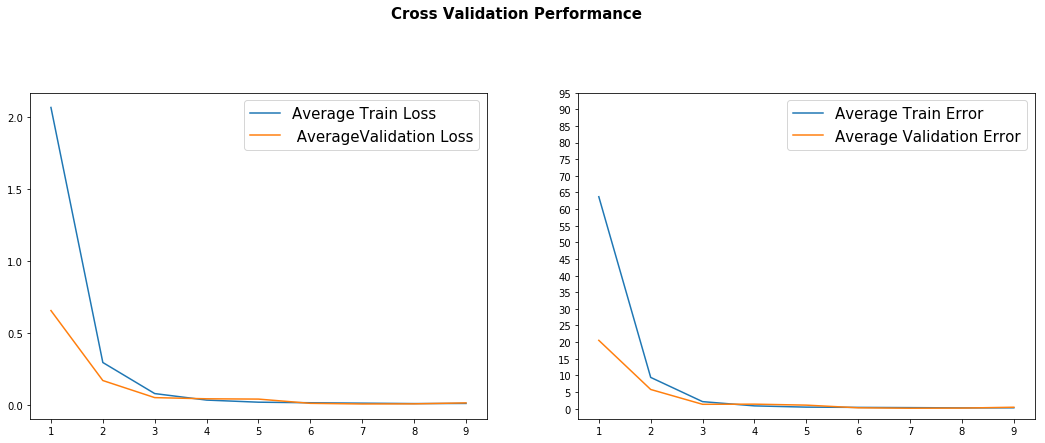

In [9]:
dropout = 0.2

CrossEval(dropout)

## Full Training

Here, we train the CNN on entire training dataset while simultaneuosly evaluating on the actual test data.


In [10]:
def FullTrain(dropout):   
                
        Cnet = convnet(classes, dropout).double()
        Cnet = Cnet.cuda()
        
        train_data, _, train_lbls, _ = CNNutils.prep_train_validate_data(train_images, train_labels, split=0.00)
        test_data, test_lbls = CNNutils.prep_test_data(test_images, test_labels)
        
        print('Train Data Shape: ', train_data.shape, '\nTest Data Shape: ', test_data.shape)
        print('\n')
        
        train_history, test_history = CNNutils.train_Cnet(Cnet, train_data, train_lbls, test_data, test_lbls, device)
        CNNutils.plot_FullTrain_history(train_history, test_history)
      
        del Cnet

In [11]:
dropout = 0.2

FullTrain(dropout)

NameError: name 'device' is not defined